# Get a raw image, display it and superimpose the position of the reference sources

In [25]:
#dataid = {'visit':2249, 'raft':'R32', 'ccd':'S21'}
#dataid = {'visit':277108, 'raftName':'R34', 'detectorName':'S22'}
##dataid = {'visit':738955, 'raftName':'R01', 'detectorName':'S01'}
#dataid = {'visit':230, 'raftName':'R43', 'detectorName':'S22'}
#dataid = {'visit':1168171, 'raftName':'R13', 'detectorName':'S20'}
#dataid = {'visit': 263504, 'filter': 'i', 'raftName': 'R33', 'detectorName': 'S01'}
#dataid = {'visit': 40328, 'raftName': 'R43', 'detectorName': 'S22'}
#dataid = {'visit':1022175, 'ccd':13}
#dataid = {'visit':3117, 'raftName':'R02', 'detectorName':'S01'}
dataid = {'visit':7976, 'raftName':'R33', 'detectorName':'S01'}

In [26]:
import lsst.daf.persistence as dafPersist
import lsst.afw.display.ds9 as ds9
import numpy

#butler = dafPersist.Butler("/sps/lsst/dataproducts/desc/DC2/Run1.2p/w_2018_30")
#butler = dafPersist.Butler("/sps/lsst/users/lsstprod/desc/DC2-test/imsim/input/rerun/test-deg3")
butler = dafPersist.Butler("/pbs/throng/lsst/users/boutigny/desc/DC2/run2.1/w_2019_19/input/rerun/test_1")

raw = butler.get('raw', dataid)
wcsRaw = raw.getWcs()

In [27]:
# Display image in ds9 (the display_ds9 stack package should be set up)
ds9.mtv(raw.getMaskedImage().getImage(),frame=1,wcs=wcsRaw)

## Create and load a catalog with reference objects 

In [11]:
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask

# Configure LoadIndexedReferenceObjectsTask
refConfig = LoadIndexedReferenceObjectsTask.ConfigClass()
refConfig.ref_dataset_name = 'cal_ref_cat'
refTask = LoadIndexedReferenceObjectsTask(butler, config=refConfig)

#define a reference filter (not critical for what we are doing) 
filter = 'lsst_r_smeared'

# Find the approximate celestial coordinates of the sensor's center 
centerPixel = afwGeom.Point2D(2000., 2000.)
centerCoord = wcsRaw.pixelToSky(centerPixel)

# Retrieve reference object within a 0.5 deg radius circle around the sensor's center
radius = afwGeom.Angle(0.5, afwGeom.degrees)
ref = refTask.loadSkyCircle(centerCoord, radius, filter).refCat.copy(deep=True)

In [12]:
# We can now display the reference catalog as an astropy table
ref.asAstropy()

id,coord_ra,coord_dec,lsst_u_smeared_flux,lsst_g_smeared_flux,lsst_r_smeared_flux,lsst_i_smeared_flux,lsst_z_smeared_flux,lsst_y_smeared_flux,lsst_u_smeared_fluxErr,lsst_g_smeared_fluxErr,lsst_r_smeared_fluxErr,lsst_i_smeared_fluxErr,lsst_z_smeared_fluxErr,lsst_y_smeared_fluxErr,resolved,variable,ra,dec,sigma_ra,sigma_dec,lsst_u,lsst_g,lsst_r,lsst_i,lsst_z,lsst_y,u_rms,g_rms,r_rms,i_rms,z_rms,y_rms,properMotionRa,properMotionDec,parallax,radialVelocity,centroid_x,centroid_y,hasCentroid
,rad,rad,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
103103783938,1.142786562492787,-0.5341562511774886,956.6476301715451,2584.068369052059,4372.683059659928,5365.719924794859,5754.240375637595,5803.687235731017,0.881158284903036,2.380158775637999,4.027633356059829,4.942309390715217,5.300171578752991,5.345716572604015,False,False,65.4768469,-30.6048988,2.7778e-08,2.7778e-08,23.94903,22.86996,22.29871,22.07706,22.00117,21.98933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,False
31040555814914,1.1423957184587186,-0.5332897422876206,391.92593220958787,2969.8328037052897,10302.6275513781,51247.89128173084,113420.61556697081,191624.9259335914,0.36099894187047377,2.735482425532659,9.48964418752513,47.20390513966945,104.47056150415298,176.50374678713874,False,False,65.4544532,-30.5552515,2.7778e-08,2.7778e-08,24.91756,22.71861,21.36979,19.62571,18.76349,18.19394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,False
31040555835394,1.1428359934495533,-0.5333014639642555,330.95427856199245,2666.41657300036,9476.588003533563,48006.49512466822,106880.8748577728,180857.28208645,0.3048385793071095,2.4560088586439215,8.728787662839807,44.21828850469548,98.44687365370156,166.5857808762291,False,False,65.4796791,-30.5559231,2.7778e-08,2.7778e-08,25.10058,22.83352,21.45914,19.69572,18.82857,18.25709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,False
31040555876354,1.142305916278807,-0.5335711888886973,147.60871516174197,1369.6197186808024,4124.164693693783,12835.831283046082,21149.105322570857,26725.38682911704,0.13596086812585104,1.2615426247026222,3.798725647291069,11.822952069243566,19.480223214401807,24.6164787106535,False,False,65.4493079,-30.5713772,2.7778e-08,2.7778e-08,25.97615,23.55845,22.3622,21.12789,20.58605,20.33309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,False
31040555925506,1.1429597639097908,-0.533645302851996,3505.7746794346535,32850.04735850585,99222.91917671441,309790.431804903,510138.3815464245,645232.1516950374,3.2291329705517473,30.257840480108584,91.3932095030102,285.3447779091136,469.8832121353313,594.3166932321179,False,False,65.4867706,-30.5756236,2.7778e-08,2.7778e-08,22.5367,20.10868,18.90893,17.67229,17.12972,16.87648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,False
31040556205058,1.14362100936141,-0.5345482260801927,9561.719517570175,85245.60551816852,250913.4835549396,408435.9865541649,513031.46279127797,580411.488296476,8.807201424118084,78.51884976753733,231.1138269256678,376.20618298109537,472.54799949004735,534.6110474069031,False,False,65.5246572,-30.6273573,2.7778e-08,2.7778e-08,21.44858,19.07377,17.90039,17.37371,17.12514,16.98889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,False
31040556352514,1.1452444905094195,-0.5348284196919462,248.4734556563188,1622.631863747769,4478.329043139356,30327.457304944804,72251.02289448223,123961.83601289516,0.22886634234466413,1.494589507144456,4.124942783976286,27.934308748042604,66.54967347253627,114.17997115088981,False,False,65.6176758,-30.6434112,2.7778e-08,2.7778e-08,25.41296,23.37361,22.27222,20.19577,19.25312,18.66691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,False
31040556393474,1.1440476114306675,-0.5351157409491121,130.70

## Display the bright reference sources as a small circle overlaid on the ds9 image

In [13]:
for r in ref:
    ra = r.get("coord_ra")
    dec = r.get("coord_dec")
    mag = r.get("lsst_r")
    res = r.get("resolved")
    c = afwGeom.SpherePoint(ra, dec)
    pt = wcsRaw.skyToPixel(c)
    # Ignore sources which lye outside the sensor footprint or which are too faint 
    if (pt.getX() > 4000) or (pt.getX()<0) or (pt.getY()>4000) or (pt.getY()<0) or mag > 22 or res==False:
        continue
    with ds9.Buffering():
        ds9.dot('o', pt.getX(), pt.getY(), frame=1, size=8)

### Note that reference sources does not exactly match the sources in the raw images 
### this is due to the non-physical extra pixels  

## We can now redo the same thing with the calibrated exposure (calexp)

In [8]:
import lsst.daf.persistence as dafPersist
import lsst.afw.display.ds9 as ds9
import numpy

# We need to get a new butler as calexp are in the output directory while eImage(raw) was in the input

#butler = dafPersist.Butler("/sps/lsst/dataproducts/desc/DC2/Run1.2p/w_2018_18/data/output")
#butler = dafPersist.Butler("/sps/lsst/users/lsstprod/desc/DC2-test/newCam/input/rerun/jointcal2")
#butler = dafPersist.Butler("/sps/lsst/dataproducts/desc/DC2/Run1.2p/w_2018_30/rerun/210918")
#butler = dafPersist.Butler("/sps/lsst/dataproducts/desc/DC2/Run1.2p/w_2018_30/rerun/210918")
calexp = butler.get('calexp', dataid)
wcs = calexp.getWcs()

In [9]:
# display in another frame
ds9.mtv(calexp.getMaskedImage().getImage(),frame=2,wcs=wcs)

In [23]:
# display in another frame
ds9.mtv(calexp.getMaskedImage(),frame=2,wcs=wcs)

In [ ]:
import lsst.afw.geom as afwGeom
meta = butler.get('calexp_md', dataid)
wcs = afwGeom.makeSkyWcs(meta)
bbox = butler.get('calexp_bbox', dataid)
butler.getKeys()

In [11]:
for r in ref:
    ra = r.get("coord_ra")
    dec = r.get("coord_dec")
    mag = r.get("lsst_r")
    c = afwGeom.SpherePoint(ra, dec)
    pt = wcs.skyToPixel(c)
    # Ignore sources which lie outside the sensor footprint or which are too faint 
    if (pt.getX() > 4000) or (pt.getX()<0) or (pt.getY()>4000) or (pt.getY()<0) or mag > 22:
        continue
    with ds9.Buffering():
        ds9.dot('o', pt.getX(), pt.getY(), frame=2, size=8)

In [ ]:
import lsst.afw.geom as afwGeom
src = butler.get('src', dataid)
for s in src:
    ra = s.get("coord_ra")
    dec = s.get("coord_dec")
    c = afwGeom.SpherePoint(ra, dec)
    pt = wcs.skyToPixel(c)
    with ds9.Buffering():
        ds9.dot('o', pt.getX(), pt.getY(), frame=2, size=8)

In [24]:
ra = []
dec = []
for r in ref:
    mag = r.get("lsst_u")
    res = r.get("resolved")
#    c = afwCoord.IcrsCoord(ra, dec)
#    pt = wcsRaw.skyToPixel(c)
    if mag > 21 or res==False:
        continue
    ra.append(afwGeom.radToDeg(r.get("coord_ra")))
    dec.append(afwGeom.radToDeg(r.get("coord_dec")))

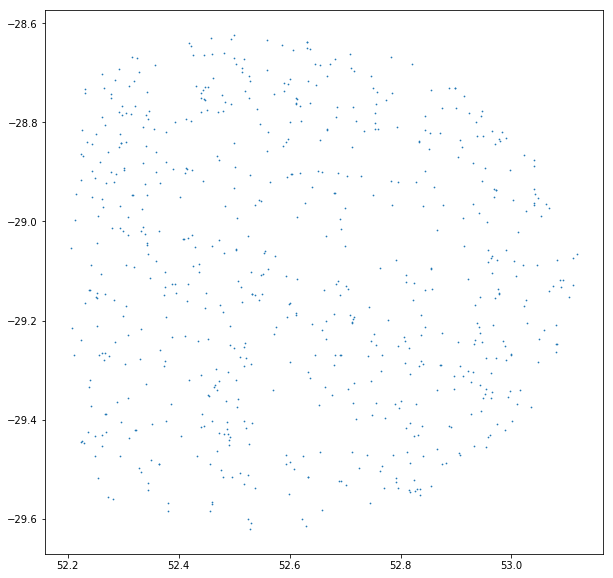

In [25]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

fig, (ax0) = plt.subplots(ncols=1, figsize=(10, 10))
_ = ax0.scatter(ra, dec, s=0.5)

In [ ]:
ref['id']%1024

In [ ]:
srcA = butler.get('src', dataid).asAstropy()
refA = ref.asAstropy()

In [ ]:
fluxType = "base_CircularApertureFlux_6_0"

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         fluxType + "_flag", "base_SdssCentroid_flag", 
         "base_SdssCentroid_flag_almostNoSecondDerivative", "base_SdssCentroid_flag_edge", "base_SdssCentroid_flag_noSecondDerivative",
         "base_SdssCentroid_flag_notAtMaximum", "base_SdssCentroid_flag_resetToPeak", 
         "base_SdssShape_flag", "base_ClassificationExtendedness_flag"]

# select sources
cut = np.ones_like(srcA['id'], dtype=bool)
for flag in Flags:
    cut &= srcA[flag]==False
cut &= (srcA[fluxType + '_flux'] > 0) & (srcA[fluxType + '_flux'] / srcA[fluxType + '_fluxSigma'] > 5)
#cut &= srcA['base_ClassificationExtendedness_value'] < 0.5

cat = srcA[cut]['id', 'coord_ra', 'coord_dec']

In [ ]:
from astropy.coordinates import SkyCoord
from astropy import units as u

cut1 = (refA['id']%1024 == 231)
cut2 = (refA['id']%1024 == 4)

cRef = SkyCoord(ra = refA['coord_ra'], dec = refA['coord_dec'])
cRef1 = SkyCoord(ra = refA[cut1]['coord_ra'], dec = refA[cut1]['coord_dec'])
cRef2 = SkyCoord(ra = refA[cut2]['coord_ra'], dec = refA[cut2]['coord_dec'])
cCat = SkyCoord(ra = cat['coord_ra'], dec = cat['coord_dec'])

In [ ]:
idx, d2d, d3d = cCat.match_to_catalog_sky(cRef)
idx1, d2d1, d3d1 = cCat.match_to_catalog_sky(cRef1)
idx2, d2d2, d3d2 = cCat.match_to_catalog_sky(cRef2)

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 8))
_ = ax0.hist(d2d.arcsec, bins=50, range=[0, 20])
_ = ax1.hist(d2d1.arcsec, bins=50, range=[0,20])
_ = ax2.hist(d2d2.arcsec, bins=50, range=[0,20])
ax0.set_xlabel('Ang dist in arcsec star + galaxies')
ax1.set_xlabel('Ang dist in arcsec galaxies only')
ax2.set_xlabel('Ang dist in arcsec star only')
fig.tight_layout()

In [ ]:
fig.savefig("refCat.png")

## Same thing with coadd

In [1]:
import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.display.ds9 as ds9
import numpy

dataid = {'tract': 5065, 'patch': '0,2', 'filter': 'i' }
butler = dafPersist.Butler("/sps/lsst/dataproducts/desc/DC2/Run1.2p/w_2018_30/rerun/coadd-all2")

coadd = butler.get('deepCoadd', dataid)
wcs = coadd.getWcs()

In [16]:
ds9.mtv(coadd.getMaskedImage().getImage(),frame=1,wcs=wcs)

In [7]:
#src = butler.get('deepCoadd_det', dataid)
src = butler.get('deepCoadd_meas', dataid)
len(src)

38877

In [19]:
tab = src.asAstropy()

In [17]:
for s in src:
#    if src.get("merge_footprint_u")
    ra = s.get("coord_ra")
    dec = s.get("coord_dec")
#    flux = s.get("modelfit_CModel_instFlux")
#    fluxErr = s.get("modelfit_CModel_instFluxErr")
    flux = s.get("slot_PsfFlux_instFlux")
    fluxErr = s.get("slot_PsfFlux_instFluxErr")
#    if s.get('merge_peak_i') == False:
#        continue
    if flux <= 0 or flux/fluxErr < 10 :
        continue
    #if s.get('merge_peak_sky') == False:
    #if flux > 0 :
    if s.get("detect_isPrimary") == False :
        continue
    c = afwGeom.SpherePoint(ra, dec)
    pt = wcs.skyToPixel(c)
    with ds9.Buffering():
        ds9.dot('o', pt.getX(), pt.getY(), frame=1, size=8)

In [8]:
slot = src.getCalibFluxSlot()
slot.getMeasKey()

Key<D>(offset=-1, nElements=1)

In [11]:
slot.getName()

'CalibFlux'

In [ ]:
for s in src:
    ra = s.get("coord_ra")
    dec = s.get("coord_dec")
    if s.get('merge_peak_i') == False:
        continue
    flux = s.get("modelfit_CModel_instFlux")
#    if flux <= 0 or s.get("detect_isPrimary") == False :
#        continue
    print(s.get("modelfit_CModel_instFlux"), s.get("detect_isPrimary") )
    c = afwGeom.SpherePoint(ra, dec)
    pt = wcs.skyToPixel(c)
#    with ds9.Buffering():
#        ds9.dot('o', pt.getX(), pt.getY(), frame=1, size=8)

In [26]:
flux = src.getCalibInstFlux()
src.getM

array([        nan,         nan,  2.87818837, ..., -1.89377129,
        1.72160208,  1.15762198])

In [29]:
md = butler.get('deepCoadd_calexp', dataid)
calib = md.getCalib()

In [20]:
tab

id,coord_ra,coord_dec,parent,merge_footprint_i,merge_footprint_r,merge_footprint_z,merge_footprint_y,merge_footprint_g,merge_footprint_u,merge_footprint_sky,merge_peak_i,merge_peak_r,merge_peak_z,merge_peak_y,merge_peak_g,merge_peak_u,merge_peak_sky,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psfFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xSigma,base_SdssCentroid_xErr,slot_Centroid_xSigma,base_SdssCentroid_ySigma,base_SdssCentroid_yErr,slot_Centroid_ySigma,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_InputCount_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_convolved_ConvolvedFlux_0_flag_badCentroid,ext_convolved_ConvolvedFlux_1_flag_badCentroid,ext_convolved_ConvolvedFlux_2_flag_badCentroid,ext_convolved_ConvolvedFlux_3_flag_badCentroid,ext_convolved_ConvolvedFlux_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,ext_shapeHSM_HsmPsfMoments_flag_badCentroid,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,modelfit_DoubleShapeletPsfApprox_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_InputCount_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_0_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_1_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_2_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_3_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_flag_badCentroid_edge,ext_photometryKron_KronFlux_flag_badInitialCentroid_edge,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,modelfit_DoubleShapeletPsfApprox_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_InputCount_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_0_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_1_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_2_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_3_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_flag_badCentroid_noSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,modelfit_DoubleShapeletPsfApprox_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCe

In [15]:
len(numpy.isnan(tab['coord_ra']))

7362

In [16]:
numpy.sum(numpy.isnan(tab['coord_ra']))

7362

In [17]:
numpy.sum(tab['parent'])

0